# Vehicle Detection and Tracking

## Introduction

The purpose of this project is to build a model to detect and track vehicles while driving on a highway.  Video images will be processed frame by frame.  The detected vehicles will be labeled by a blue bounding box.  A pretrained VGG16 Imagenet model will be used for detecting vehicles.  It will be fine tuned to differentiate between objects in the frame which are vehicles and objects which are not vehicles.

In [2]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from imageio import imwrite

from keras import backend as K
img_dim_ordering = 'tf'
K.set_image_dim_ordering(img_dim_ordering)

import numpy as np

Using TensorFlow backend.


In [3]:
from scipy.ndimage.measurements import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [4]:
from moviepy.editor import *
from IPython.display import HTML

In [5]:
from util import *

# Data

In [6]:
data_dir = 'data'

## Vehicle/Not Vehicle

The VGG16 model has already been pretrained to identify many different types of objects but we only need to it to detect vehicle/not vehicle.  We will use 8792 images of vehicles and 8968 images of non-vehicles to fine tune our model. In total, there are 17760 images. The images are RGB images. The dimensions of those images are 64x64.

In [7]:
def fix_path_delimiter(path_str):
    # for Windows
    return path_str.replace('\\', '/')

### Vehicle

In [8]:
vehicle_dir = '%s/vehicles' % data_dir
vehicle_img_files = sorted(glob.glob('%s/*/*.png' % vehicle_dir))
vehicle_img_files = [fix_path_delimiter(x) for x in vehicle_img_files]
vehicle_imgs = read_imgs(vehicle_img_files, scale_to_255=True)
len(vehicle_imgs)

8792

Here are some samples of vehicles:

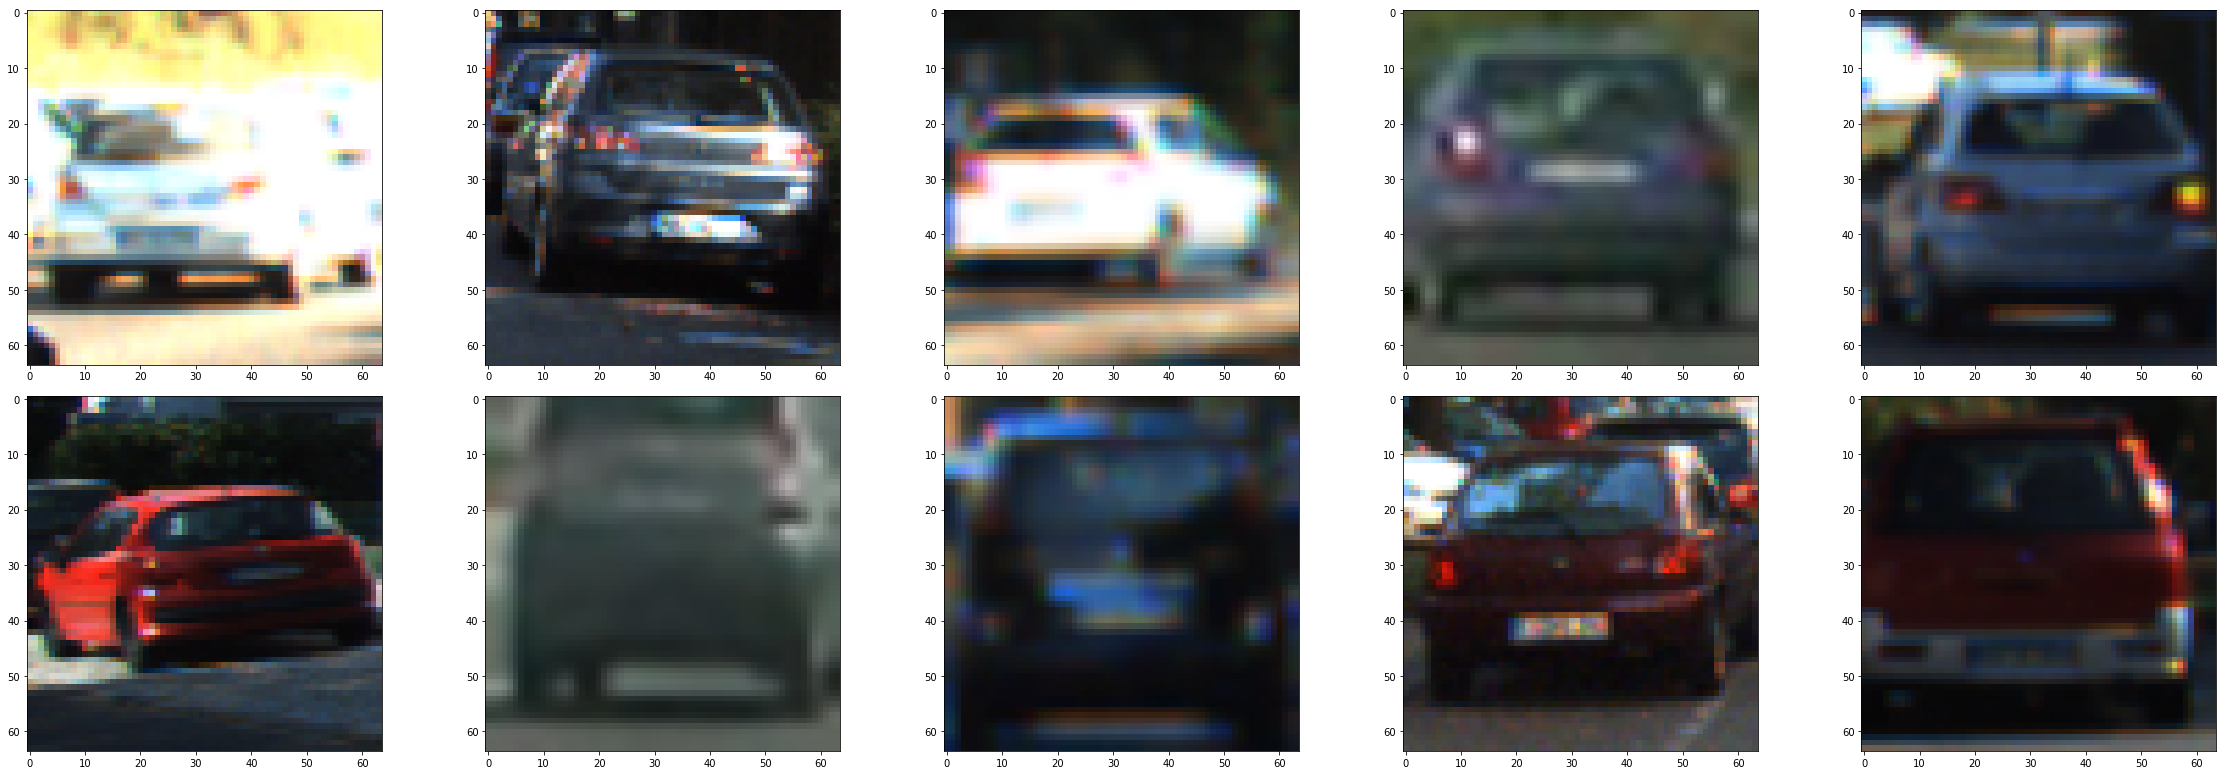

In [9]:
sample_idxs = list(range(len(vehicle_imgs)))
random.shuffle(sample_idxs)
display_images(vehicle_imgs[sample_idxs[:10]], figsize=(32,16))

In [10]:
vehicle_imgs[0].min(), vehicle_imgs[0].max()

(33, 192)

### Non-Vehicle

In [11]:
non_vehicle_dir = '%s/non-vehicles' % data_dir
non_vehicle_img_files = sorted(glob.glob('%s/*/*.png' % non_vehicle_dir))
non_vehicle_img_files = [fix_path_delimiter(x) for x in non_vehicle_img_files]
len(non_vehicle_img_files)

8968

#### Bad Non-Vehicle Images

In [12]:
exclude_non_vehicle_img_files = pd.read_csv('%s/non_vehicle_exclude.csv' % non_vehicle_dir)['img_file']
exclude_non_vehicle_img_files = ['%s/%s' % (data_dir, x) for x in exclude_non_vehicle_img_files]

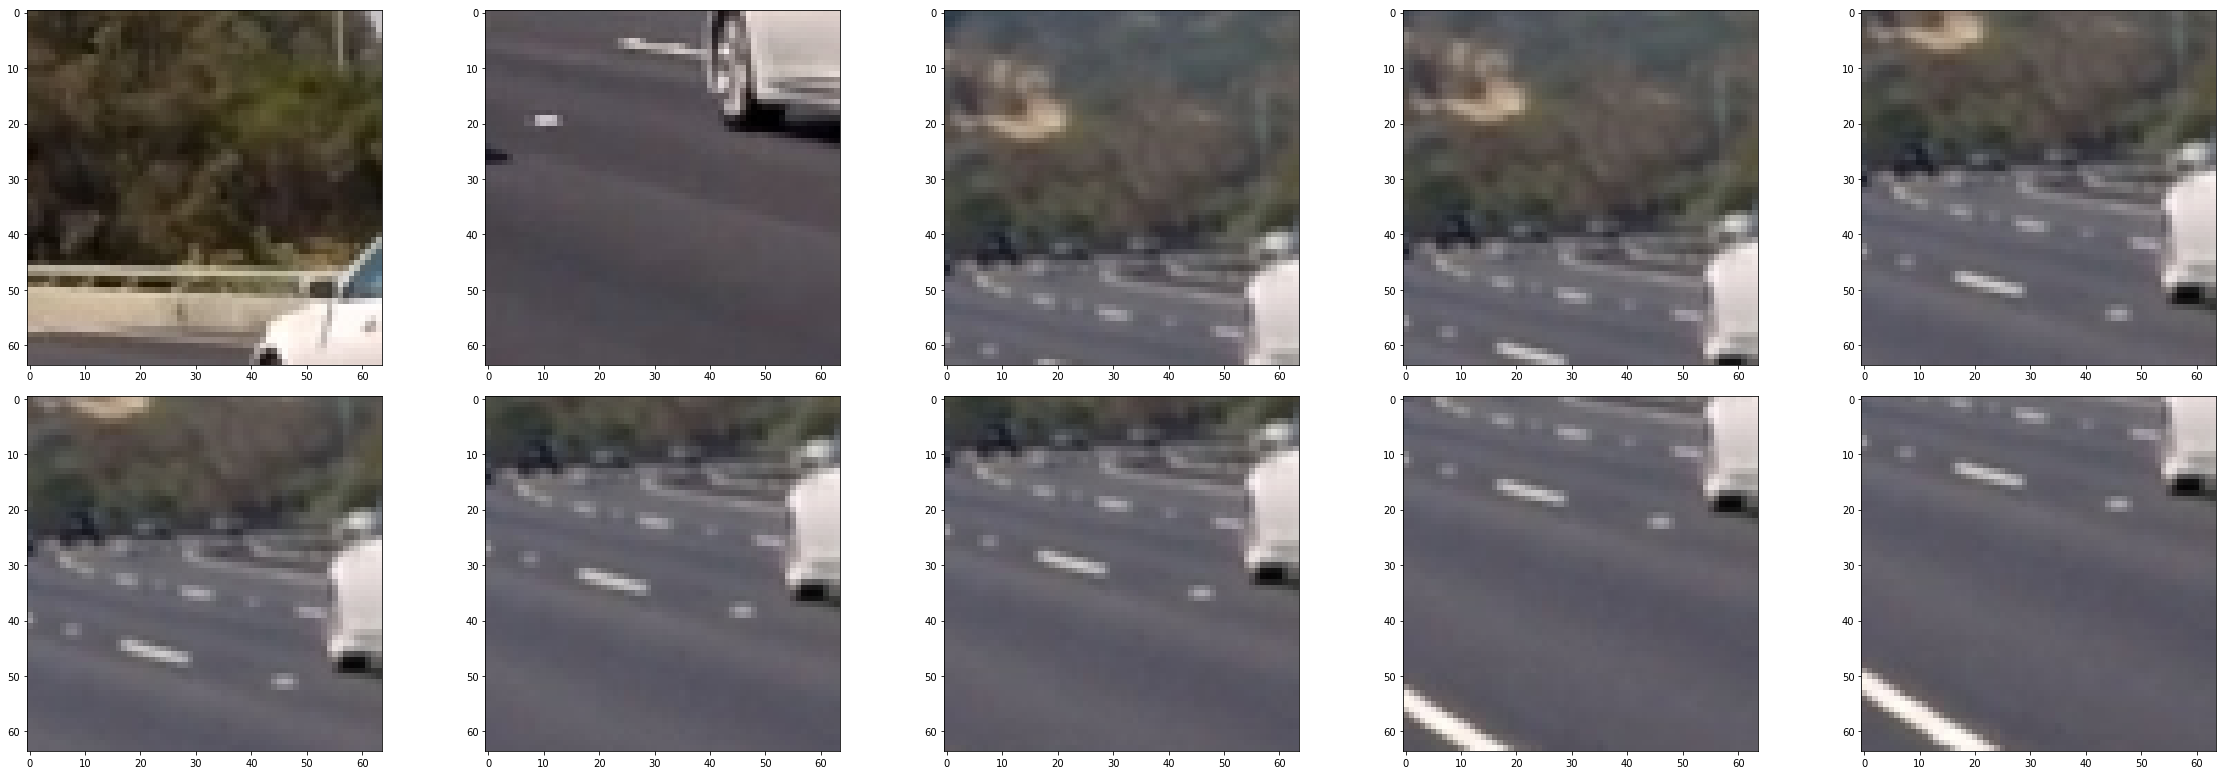

In [13]:
display_images(exclude_non_vehicle_img_files, start_idx=0, end_idx=10, figsize=(32,16), 
               apply_fnc=lambda x: read_img(x, scale_to_255=False))

In [14]:
non_vehicle_img_files = list(set(non_vehicle_img_files)-set(exclude_non_vehicle_img_files))

In [15]:
non_vehicle_imgs = read_imgs(non_vehicle_img_files, scale_to_255=True)
len(non_vehicle_imgs)

8515

Here are some samples of non-vehicles:

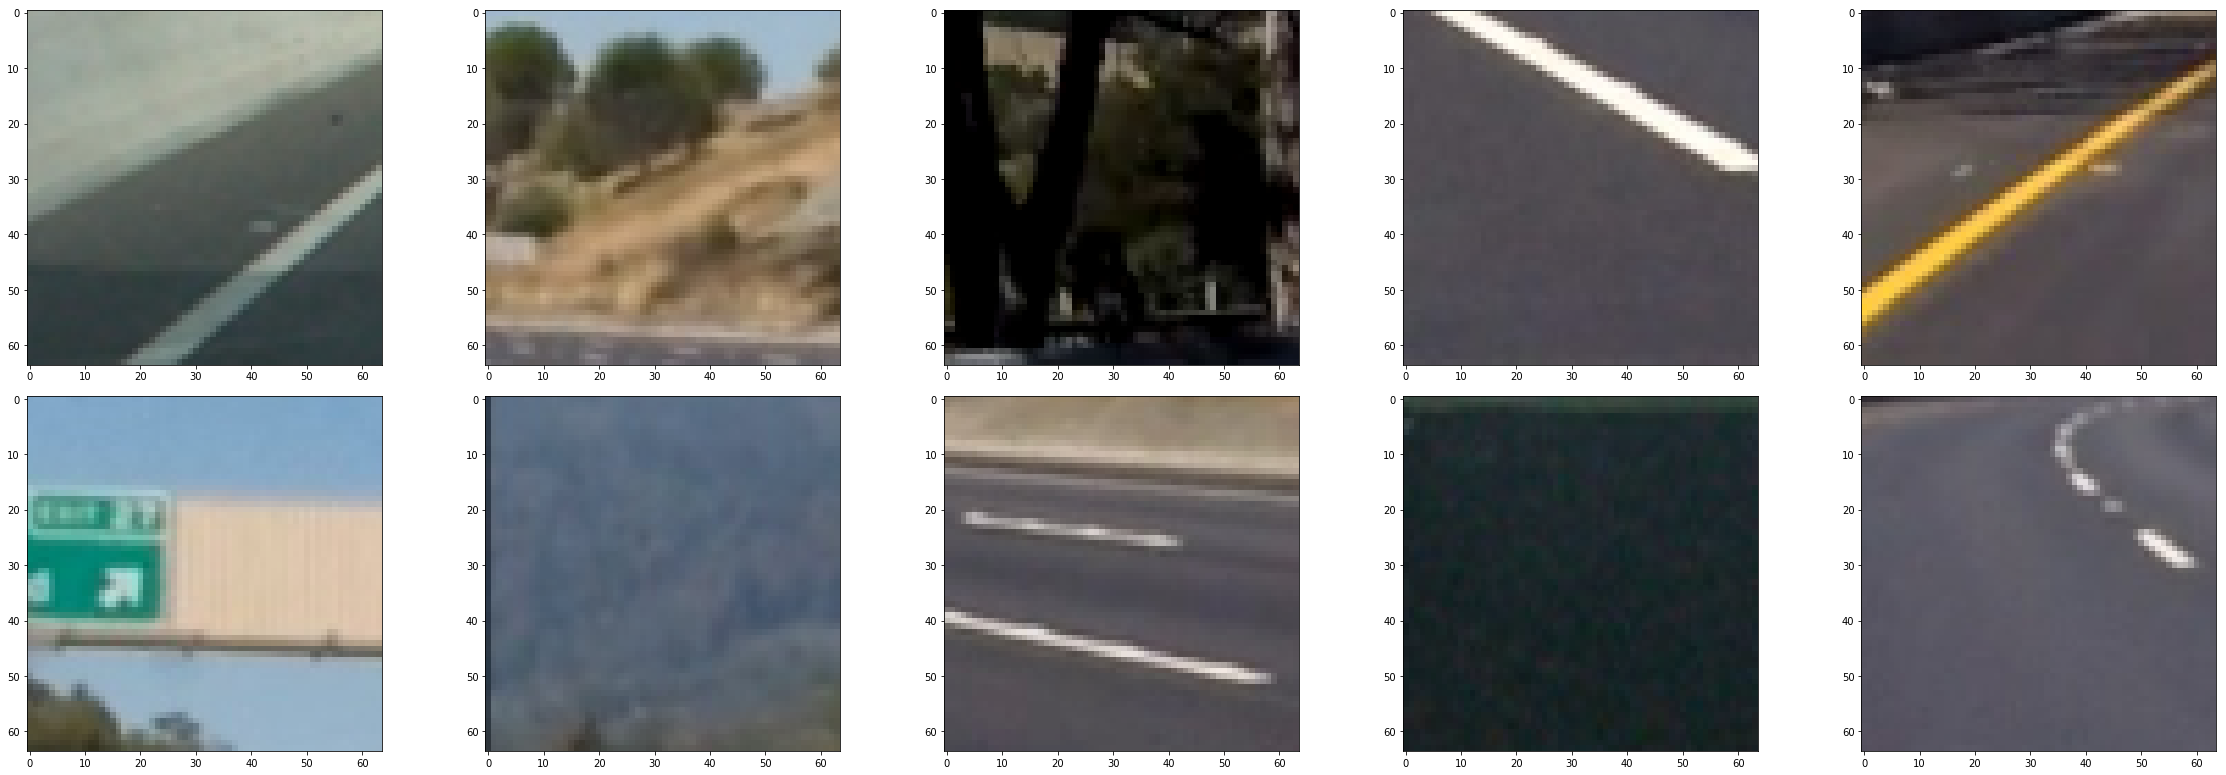

In [16]:
sample_idxs = list(range(len(non_vehicle_imgs)))
random.shuffle(sample_idxs)
display_images(non_vehicle_imgs[sample_idxs[:10]], figsize=(32,16))

In [17]:
non_vehicle_imgs[0].min(), non_vehicle_imgs[0].max()

(0, 191)

## Train, Val, Test

From the 17760 images, the images will be split into x train, x validation and x test images.

In [18]:
X_img_files = vehicle_img_files + non_vehicle_img_files
y = [1.0]*len(vehicle_img_files) + [0.0]*len(non_vehicle_img_files)

In [19]:
X_train_imgs_filename = '%s/X_train_imgs.csv' % data_dir
X_val_imgs_filename = '%s/X_val_imgs.csv' % data_dir
X_test_imgs_filename = '%s/X_test_imgs.csv' % data_dir
y_train_filename = '%s/y_train.csv' % data_dir
y_val_filename = '%s/y_val.csv' % data_dir
y_test_filename = '%s/y_test.csv' % data_dir

In [20]:
if not do_files_exists([X_train_imgs_filename, X_val_imgs_filename, X_test_imgs_filename, 
                       y_train_filename, y_val_filename, y_test_filename]):
    X_train_img_files, X_test_img_files, y_train, y_test = train_test_split(X_img_files, y, test_size=0.3, 
                                                                            random_state=5150)
    X_val_img_files, X_test_img_files, y_val, y_test = train_test_split(X_test_img_files, y_test, test_size=0.33,
                                                                    random_state=5150)
    assert len(X_train_img_files) + len(X_val_img_files) + len(X_test_img_files) == len(X_img_files)
    assert len(y_train) + len(y_val) + len(y_test) == len(y)    
    
    save_img_file_csv(X_train_img_files, X_train_imgs_filename)
    save_img_file_csv(X_val_img_files, X_val_imgs_filename)
    save_img_file_csv(X_test_img_files, X_test_imgs_filename)
    save_label_file_csv(y_train, y_train_filename)
    save_label_file_csv(y_val, y_val_filename)
    save_label_file_csv(y_test, y_test_filename)
else:
    X_train_img_files = read_img_file_csv(X_train_imgs_filename)
    X_val_img_files = read_img_file_csv(X_val_imgs_filename)
    X_test_img_files = read_img_file_csv(X_test_imgs_filename)
    y_train = read_label_file_csv(y_train_filename)
    y_val = read_label_file_csv(y_val_filename)
    y_test = read_label_file_csv(y_test_filename)

In [21]:
def flip_imgs(imgs):
    flip_img_arr = []
    
    for i in tqdm(range(imgs.shape[0])):
        flip_img_arr.append(np.fliplr(imgs[i]))
        
    return np.stack(flip_img_arr)

In [22]:
def flip_and_add_imgs(imgs):
    flipped_imgs = flip_imgs(imgs)
    
    return np.concatenate([imgs, flipped_imgs])

In [23]:
def vgg_load_imgs(X_img_files):
    X_img_arr = []
    for img_path in tqdm(X_img_files):
        #print(img_path)
        curr_img = image.load_img(img_path, target_size=(64, 64))
        X_img_arr.append(curr_img.copy())
        curr_img.close()

    X_imgs = np.stack(X_img_arr)    
    
    return X_imgs.astype(np.float32)/255.0

In [24]:
X_train = vgg_load_imgs(X_train_img_files)
X_val = vgg_load_imgs(X_val_img_files)
X_test = vgg_load_imgs(X_test_img_files)

100%|████████████████████████████████████████████████████████████████████████████| 1714/1714 [00:00<00:00, 3995.35it/s]


In [25]:
X_train = flip_and_add_imgs(X_train)
y_train = y_train*2
print(X_train.shape, len(y_train))

X_val = flip_and_add_imgs(X_val)
y_val = y_val*2
print(X_val.shape, len(y_val))

X_test = flip_and_add_imgs(X_test)
y_test = y_test*2
print(X_test.shape, len(y_test))

100%|████████████████████████████████████████████████████████████████████████| 12114/12114 [00:00<00:00, 931947.88it/s]


(24228, 64, 64, 3) 24228


100%|██████████████████████████████████████████████████████████████████████████| 3479/3479 [00:00<00:00, 869968.62it/s]


(6958, 64, 64, 3) 6958


100%|██████████████████████████████████████████████████████████████████████████| 1714/1714 [00:00<00:00, 856959.95it/s]


(3428, 64, 64, 3) 3428


## Videos for Detection

We will use two models to test our model - a project video and a test video.

### Project Video 

In [26]:
output_dir = 'output_images' 
project_video_file = 'project_video.mp4'

In [27]:
extract_video_imgs(project_video_file, output_dir)

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1248/1259 [00:24<00:00, 53.11it/s]

In [28]:
project_img_files = sorted(glob.glob('%s/*.jpg' % output_dir))

Here are some sample frames of the Project Video:

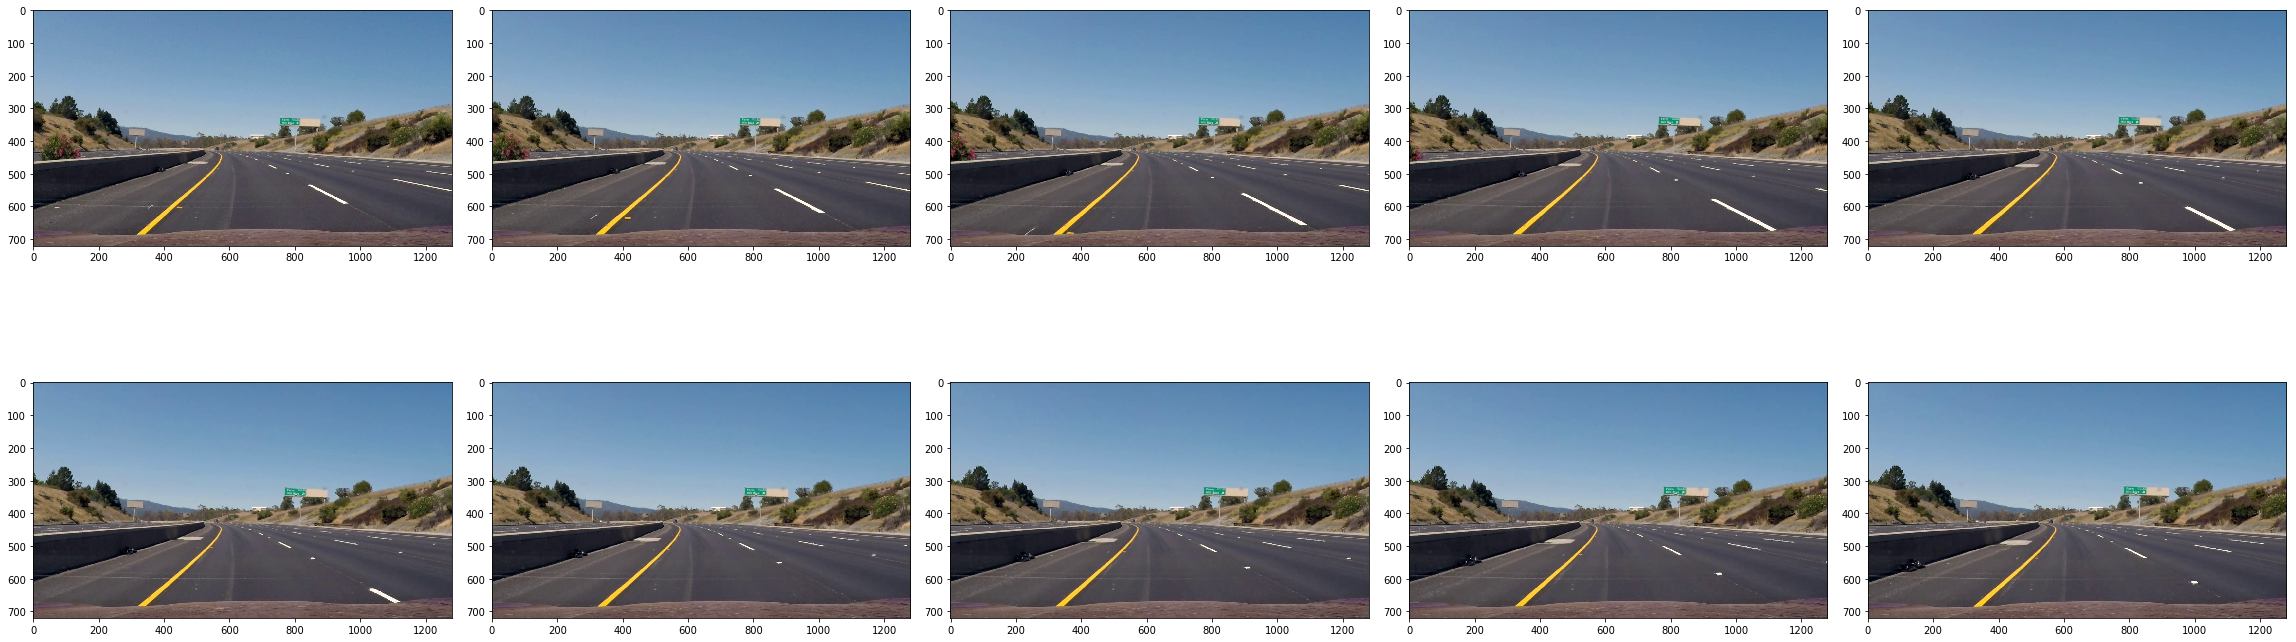

In [29]:
display_images(project_img_files, figsize=(32,16), start_idx=0, end_idx=10, 
               apply_fnc=lambda x: read_img(x, scale_to_255=False))

## Test Video

In [30]:
test_output_dir = 'test_images2' 
test_video_file = 'test_video.mp4'

In [31]:
extract_video_imgs(test_video_file, test_output_dir)


 68%|███████████████████████████████████████████████████████▍                          | 25/37 [00:00<00:00, 47.09it/s]

In [32]:
test_img_files = sorted(glob.glob('%s/*.jpg' % test_output_dir))

Here are some examples of the test video:

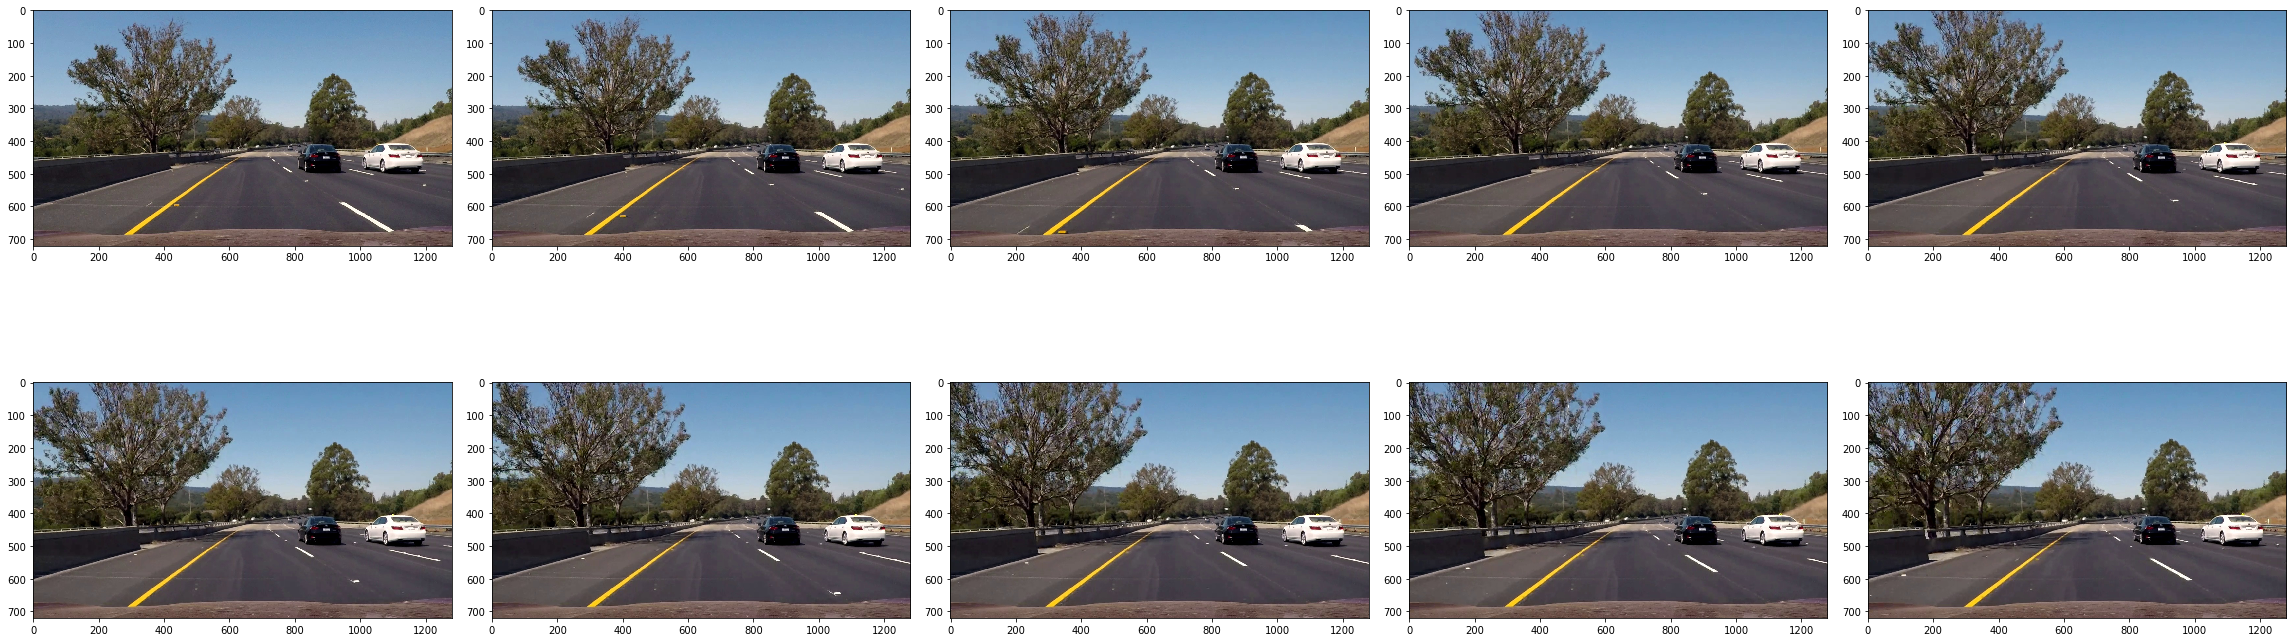

In [33]:
display_images(test_img_files, figsize=(32,16), start_idx=0, end_idx=10,
               apply_fnc=lambda x: read_img(x, scale_to_255=False))

# Model

For the VGG16 model, we will use Keras' pretrained VGG16 model with Imagenet loaded weights.  The top layer will not be included.  Two Dense layers will be added on top of that. The VGG16 layers will be locked so that the pretrained weights and biases won't change during training.  Only the added Dense layers will be trained.

In [34]:
def pretrained_model(img_shape, num_classes, activation='relu', n=4096, lr=0.001):
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    num_of_layers = len(model_vgg16_conv.layers)
    for i in range(num_of_layers):
        layer = model_vgg16_conv.layers[i]
        #print(layer.name)
        layer.trainable = False
        
    #model_vgg16_conv.summary()
    
    #Create your own input format
    keras_input = Input(shape=img_shape, name = 'image_input')
    
    #Use the generated model 
    output_vgg16_conv = model_vgg16_conv(keras_input)
    
    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(n, activation=activation, name='fc1')(x)
    x = Dense(n, activation=activation, name='fc2')(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    #Create your own model 
    pretrained_model = Model(inputs=keras_input, outputs=x)
    optimizer = Adam(lr=lr)
    pretrained_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
                             metrics=['accuracy'])
    
    return pretrained_model

In [35]:
def separate_vehicle_nonvehicle_files(X, y):
    X_vehicle_arr = []
    X_nonvehicle_arr = []
    
    for i, curr_y in enumerate(y):
        if curr_y == 0:
            X_nonvehicle_arr.append(X[i])
        else:
            X_vehicle_arr.append(X[i])
            
    return np.stack(X_vehicle_arr), np.stack(X_nonvehicle_arr) 

In [36]:
X_train_vehicle, X_train_nonvehicle = separate_vehicle_nonvehicle_files(X_train, y_train) 
X_train_vehicle.shape, X_train_nonvehicle.shape

((12288, 64, 64, 3), (11940, 64, 64, 3))

One of the issues that was discovered initially with using the VGG16 model was that it had a very high accuracy for detecting full images of cars.  While processing the Project Video, I noticed that it would have trouble detecting part of a car that would start to appear on the left side.  One of the ways that I dealt with this was to fine tune the VGG16 model with segments of car images (partal car images) as well as full images of cars. Random segments of car images were taken and resized.  These images were added to augment the data.  The validation and test datasets were also augmented as well as the training dataset so loss will be consistent.  If the validation and test datasets were not augmented, their loss would only be a measurement of the loss for full car images.

In [37]:
def make_random_segment(img, seg_dim=(32, 32)):
    start_x = random.randint(0, img.shape[0]-seg_dim[0])
    start_y = random.randint(0, img.shape[1]-seg_dim[1])
    end_x = start_x + seg_dim[0]
    end_y = start_y + seg_dim[1]
    
    _img = img[start_x:end_x, start_y:end_y]
    return resize(_img, img.shape[:2])

In [38]:
def make_augmented_data(X, y, n, seg_dim_arr=[(16,16),(32, 32)]):
    augmented_img_arr = []
    augmented_y = []
    
    for i in tqdm(range(n)):
        idx = random.randint(0, X.shape[0]-1)
        img = X[idx]
        seg_dim = seg_dim_arr[random.randint(0,len(seg_dim_arr)-1)] 
        augmented_img_arr.append(make_random_segment(img, seg_dim))
        augmented_y.append(y[idx])
        
    return np.stack(augmented_img_arr), augmented_y

In [39]:
def make_augmented_vehicle_data_only(X, y, n, seg_dim_arr=[(16,16),(32, 32)]):
    X_vehicle, X_nonvehicle = separate_vehicle_nonvehicle_files(X, y) 
    
    X_vehicle_augmented, y_vehicle_augmented = make_augmented_data(X_vehicle, 
                                                                    [1]*len(X_vehicle),
                                                                    int(n*X_vehicle.shape[0]), 
                                                                    seg_dim_arr=seg_dim_arr) 
    
    _X = np.concatenate([X_vehicle, X_vehicle_augmented, X_nonvehicle])
    _y = [1]*X_vehicle.shape[0] + [1]*X_vehicle_augmented.shape[0] + [0]*X_nonvehicle.shape[0]
    
    return _X, _y

In [40]:
X_train, y_train = make_augmented_vehicle_data_only(X_train, y_train, 4, seg_dim_arr=[(32,32)])
X_val, y_val = make_augmented_vehicle_data_only(X_val, y_val, 4, seg_dim_arr=[(32,32)])
X_test, y_test = make_augmented_vehicle_data_only(X_test, y_test, 4, seg_dim_arr=[(32,32)])


100%|████████████████████████████████████████████████████████████████████████████| 6880/6880 [00:05<00:00, 1336.70it/s]


In [41]:
X_train[0].min(), X_train[0].max()

(0.015686275437474251, 0.94901961088180542)

In [42]:
model_file = '%s/model.h5' % data_dir

The input for the model is 64x64 with 3 channels for RGB.  The two Dense layers will have 1024 nodes with ReLu activations.  The learning rate is 0.001.

In [43]:
model = pretrained_model((64, 64, 3), 2, activation='relu', n=1024, lr=0.0001)

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 64, 64, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              2098176   
_________________________________________________________________
fc2 (Dense)                  (None, 1024)              1049600   
_________________________________________________________________
predictions (Dense)          (None, 2)                 2050      
Total params: 17,864,514
Trainable params: 3,149,826
Non-trainable params: 14,714,688
________________________________________________________

Only the model with the best validation loss will be saved with ModelCheckpoint.

In [45]:
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=2,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks = [checkpoint]        

In [46]:
X_train.shape, len(y_train)

((73380, 64, 64, 3), 73380)

The model will be trained for 20 epochs with a batch size of 32.

In [47]:
if not os.path.exists(model_file):
    # only train if the model doesn't exist
    model.fit(x=X_train, y=np.array(y_train), batch_size=32, epochs=20, verbose=2, callbacks=callbacks, 
              validation_data=(X_val, np.array(y_val)), shuffle=True, initial_epoch=0)

In [48]:
# load the best model
model = load_model(model_file)

In [49]:
model.evaluate(X_test, np.array(y_test))

10308/10308 [==============================] - ETA: 6: - ETA: 1: - ETA: 55s - ETA: 37 - ETA: 29 - ETA: 24 - ETA: 20 - ETA: 17 - ETA: 16 - ETA: 14 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 6s 592us/step


[0.0098114112738668987, 0.99718665114474192]

The test loss for the model is 0.017 and the test accuracy is 99.5%.

In [50]:
sample_idxs = list(range(X_test.shape[0]))
random.shuffle(sample_idxs)
sample_idxs = sample_idxs[:5]

In [51]:
model.predict(X_test[sample_idxs])

array([[  7.63563394e-29,   1.00000000e+00],
       [  9.19931666e-12,   1.00000000e+00],
       [  5.72284123e-14,   1.00000000e+00],
       [  6.12554191e-12,   1.00000000e+00],
       [  1.12036361e-11,   1.00000000e+00]], dtype=float32)

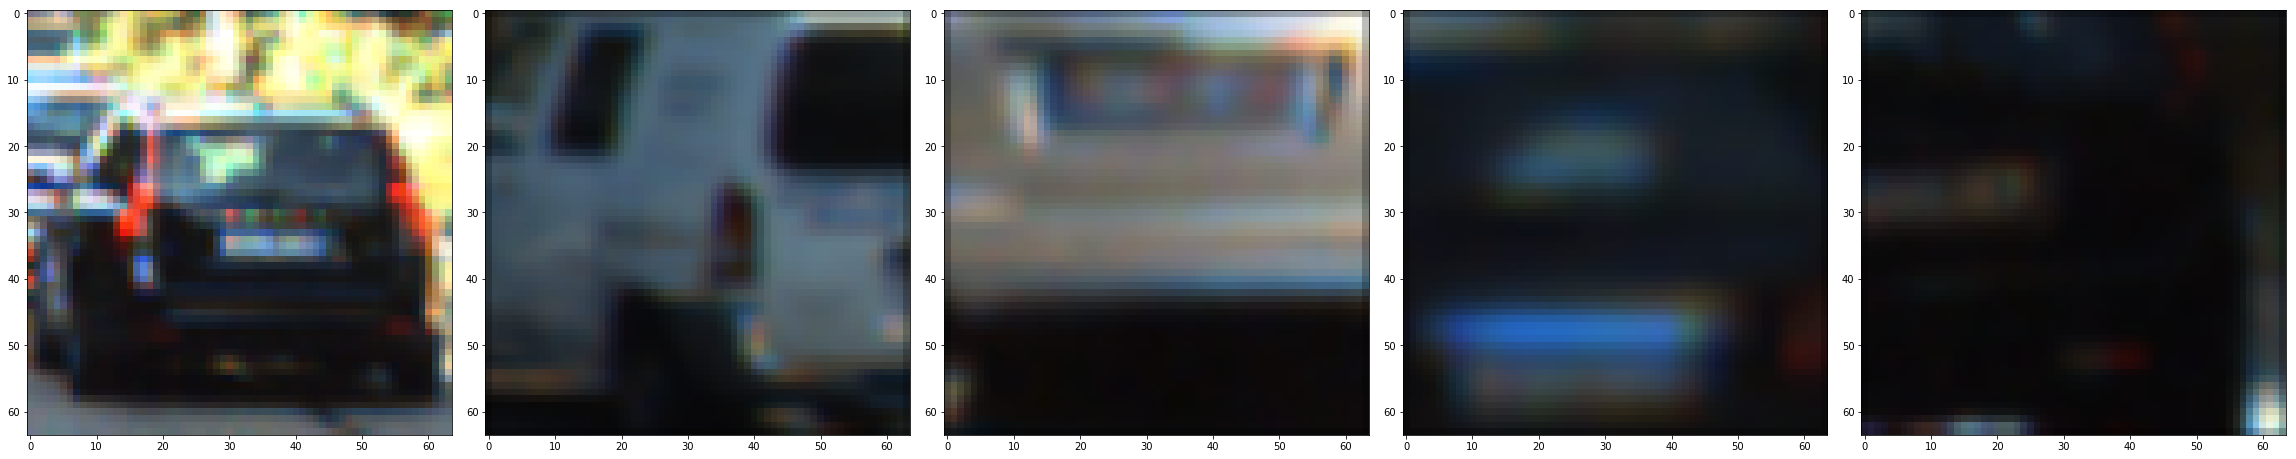

In [52]:
display_images(X_test[sample_idxs])

## Search

Now that we have a model to detect vehicle/not vehicle, all we need to do is scan across each video frame and see if that frame has vehicle in it or not.  We will use sliding windows to scan the image.  The frames will overlap each other.

As mentioned earlier, one of the issues that was discovered initially was the model had trouble detecting cars coming up from the right side.  Depending on the dimensions of the frame, the dimensions of the windows and the percent of overlap in the x directions, part of the right side of the frame wasn't getting processed when going from left to right with the sliding windows.  To deal with this issue, I added a second set of sliding windows that go from right to left.  

In [53]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    resersed_window_list = []
    x_offset = xspan % xy_window[0]
    y_offset = yspan % xy_window[1]
    reversed_window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0] + x_offset
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0] + y_offset
            endy = starty + xy_window[1]
            
            # Append window position to list
            resersed_window_list.append(((startx, starty), (endx, endy)))
        
    # Return the list of windows
    return window_list + reversed_window_list

In [54]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy

In [194]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, model, pos_threshold=0.75):    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    test_imgs = np.array([cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
                          for window in windows])
    
    predictions = model.predict(test_imgs)
    for i in range(predictions.shape[0]):
        prediction = predictions[i][1]
        
        if prediction > pos_threshold:
            """
            plt.imshow(test_imgs[i])
            plt.show()            
            print(predictions[i])
            """
            
            on_windows.append(windows[i])
            
    #8) Return windows for positive detections
    return on_windows

In [204]:
test_img = read_img('test_images/test1.jpg').astype(np.float32)/255.0
#test_img = read_img('output_images/frame_0001155.jpg').astype(np.float32)/255.0
test_img.min(), test_img.max()

(0.0, 1.0)

In [205]:
y_start_stop = [400, None]

### Windowing

Below is an example of processing a video frame with sliding windows.  In this case, 96x96 windows are slid over the video frame with an overlap of (0.5, 0.5).  The model checks for vehicles in each sliding window.  The image on the right have blue boxes for the sliding windows which the model thinks there is a vehicle.  We can see from this image, the model does a pretty good job finding where the vehicles are. 

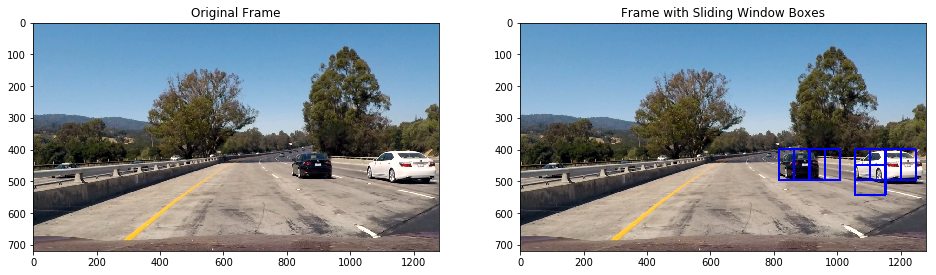

In [207]:
draw_img = np.copy(test_img)

xy_window_arr=[(64,64), (96, 96), (128,128)]
windows = []
for xy_window in xy_window_arr:
    windows += slide_window(test_img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                             xy_window=xy_window, xy_overlap=xy_overlap)

windows = slide_window(test_img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(test_img, windows, model, pos_threshold=0.99)

window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 1.0), thick=6)                    

plt.figure(figsize=(16, 16))
plt.subplot(1,2,1)
plt.title('Original Frame')
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.title('Frame with Sliding Window Boxes')
plt.imshow(window_img)
plt.show()

### Heatmaps

We will convert the sliding windows where the model has detected a vehicle into heatmaps.  The places where the sliding windows overlap indicate a higher probability of a vehicle being at place in the frame.

In [208]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_bbox_area(bbox):
    (x0, y0), (x1, y1) = bbox
    
    return (x1-x0)*(y1-y0)

def draw_labeled_bboxes(img, labels):
    _img = img.copy()
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(_img, bbox[0], bbox[1], (0,0,1.0), 6)
            
    # Return the image
    return _img

In [209]:
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, hot_windows)
print(heat.min(), heat.max())

# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

0.0 3.0


On the left, there is the image with the sliding windows from before.  The sliding windows where the model has detected a vehicle is converted to the heat map in the middle.  There is more overlap of the windows in the white and the orange areas.  From the heat map, we can come up with a more generalized bounding box for the vehicles as seen in the image on the right.  In this case, the two cars have a single bounding box around each of them.

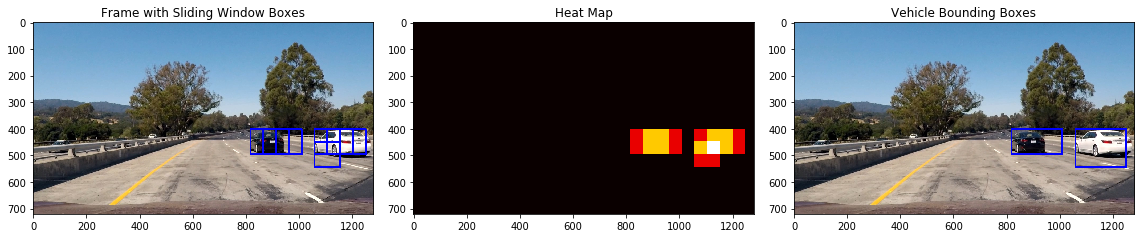

In [210]:
plt.figure(figsize=(16, 16))
plt.subplot(1,3,1)
plt.title('Frame with Sliding Window Boxes')
plt.imshow(window_img)
plt.subplot(1,3,2)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(1,3,3)
plt.imshow(draw_img)
plt.title('Vehicle Bounding Boxes')
plt.tight_layout()
plt.show()

To put this all together, get_labeled_img_with_heatmap() is the function which does most of the work.  We can limit the region of interest with x_start_stop and y_start_stop.  For our videos, we can ignore the top part of the frame because that will be the sky.  Cars far away will be smaller than cars nearby.  We can deal with that by having multiple sizes for our sliding windows with xy_window_arr.  

Heat threshold helps with removing false positives. If there is a vehicle in the frame, it should come up as positive in multiple sliding windows with different window sizes.

We can use hot windows from past frames to help with vehicle detection for the current frame.  The assumption is vehicles in the past frames should be not be very far away from where they are in the current frame.  If for some reason, we cannot detect the vehicle in the current frame, we can still use the information about where it was in the prior frames to predict where it is.

In [211]:
def get_labeled_img_with_heatmap(img, model, x_start_stop=[None, None], y_start_stop=[400, None], 
                                 xy_window_arr=[(64, 64), (128, 128)], xy_overlap=(0.5, 0.5),
                                 heat_threshold=0, hot_windows_arr=[], max_hot_windows=5,
                                 pos_threshold=0.75):    
    windows = []
    for xy_window in xy_window_arr:
        windows += slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                                xy_window=xy_window, xy_overlap=xy_overlap)
    #print(windows)

    hot_windows = search_windows(img, windows, model, pos_threshold=pos_threshold)
    
    hot_windows_arr.append(hot_windows)
    if len(hot_windows_arr) > max_hot_windows:
        hot_windows_arr = hot_windows_arr[-max_hot_windows:]
        
    hot_windows = []
    for curr_hot_windows in hot_windows_arr:
        hot_windows += curr_hot_windows
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255).astype(np.uint8)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img, heatmap, hot_windows_arr

In [212]:
draw_img, heat_map, hot_windows_arr = get_labeled_img_with_heatmap(test_img, model, 
                                                                   x_start_stop=[None, None], 
                                                                   y_start_stop=[400, None], 
                                                                   xy_window_arr=[(64, 64),(128,128)], xy_overlap=(0.5, 0.5), 
                                                                   heat_threshold=1, max_hot_windows=1, pos_threshold=0.99)

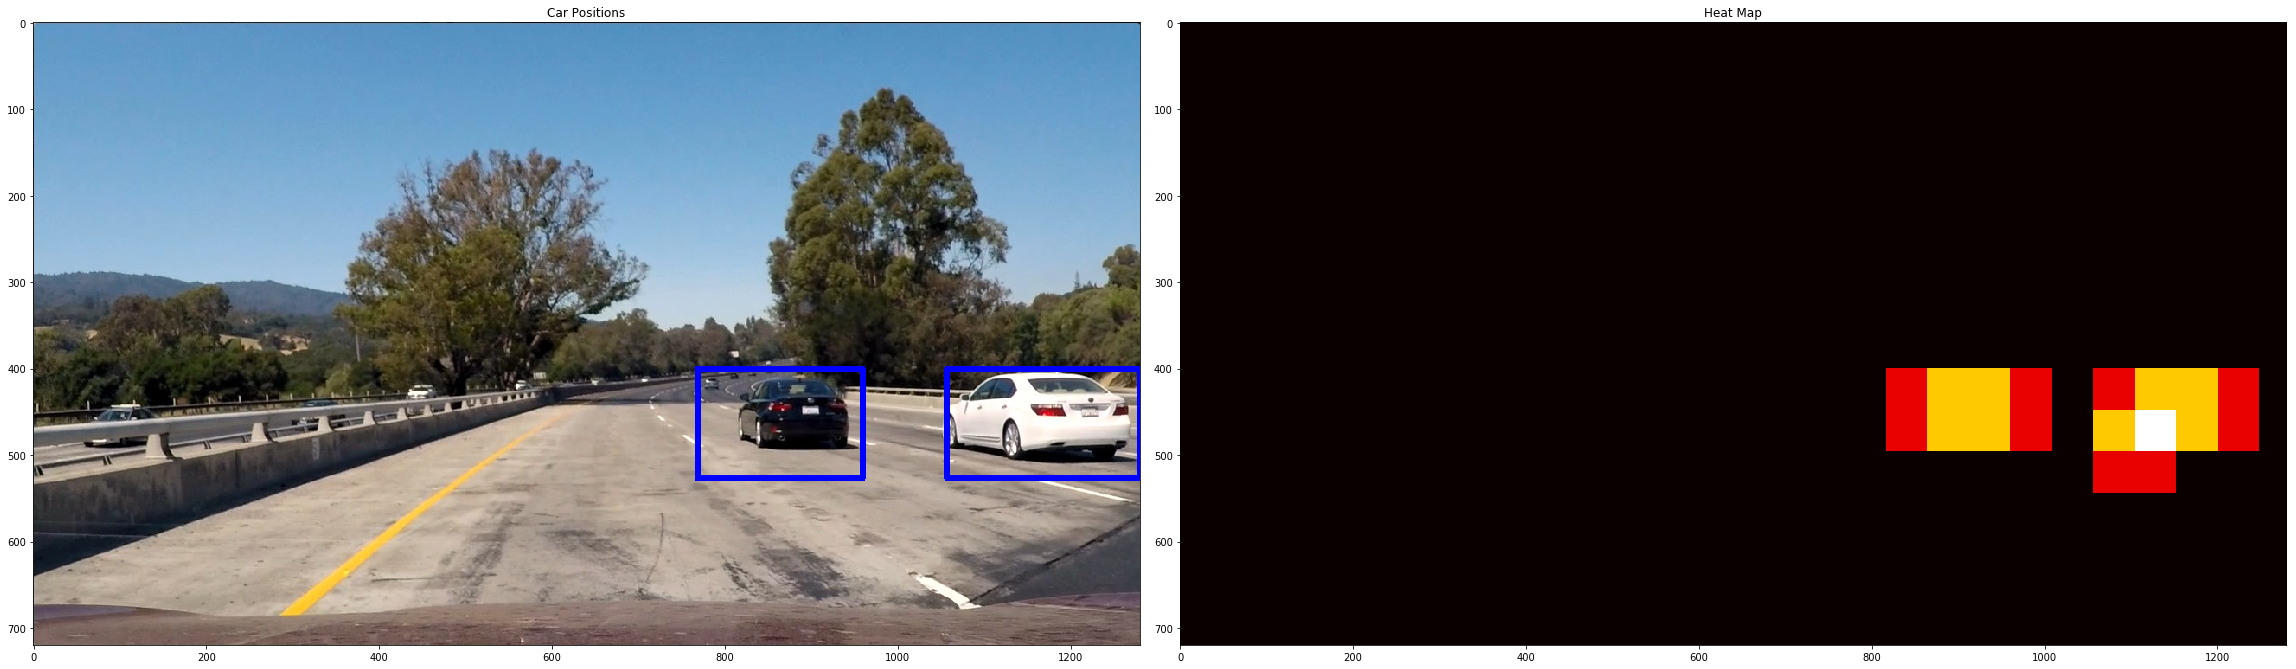

In [213]:
plt.figure(figsize=(32, 32))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.tight_layout()
plt.show()

In [214]:
output_dir = 'output_images' 

In [215]:
project_img_files = sorted(glob.glob('%s/*.jpg' % output_dir))

In [216]:
def convert_heatmap_to_img(heatmap):
    #fig = plt.figure(figsize=(24,16))
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    
    ax.imshow(heatmap, cmap="hot")
    ax.axis('tight')
    ax.axis('off')

    fig.canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    width = int(width)
    height = int(height)
    
    heatmap_img = np.fromstring(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
    
    plt.close(fig)
    
    return heatmap_img

In [217]:
def add_heatmap_to_img(img, heatmap, top_heatmap_val=10):
    small_height = int(img.shape[0]/4.0)
    small_width = int(img.shape[1]/4.0)
    
    small_heatmap = resize(convert_heatmap_to_img(heatmap), (small_height, small_width))
    
    _img = img.copy()   
    _img[:small_height, -small_width:] = small_heatmap
    
    return _img

In [218]:
def add_frame_txt(img, text_str, pos=(10,60), text_color = (12, 12, 12)):
    output_img = img.copy()
                  
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(output_img, text_str, pos, font, 2, text_color,2,cv2.LINE_AA)   
    
    return (255.0*output_img).astype(np.uint8)

In [219]:
def process_frames(img_files, model, draw_dir, x_start_stop=[None, None], y_start_stop=[400, None], 
                   xy_window_arr=[(64, 64), (128,128)], xy_overlap=(0.5, 0.5), heat_threshold=10, max_hot_windows=5,
                   start_frame_id = 0, pos_threshold=0.75):
    os.makedirs(draw_dir, exist_ok=True)
    hot_windows_arr = []
    
    for i, img_file in enumerate(tqdm(img_files)):
        img_file = img_files[i]
        img = read_img(img_file, scale_to_255=False).astype(np.float32)/255.0
    
        draw_img, heat_map, hot_windows_arr = get_labeled_img_with_heatmap(img, model, 
                                                                           x_start_stop=x_start_stop, 
                                                                           y_start_stop=y_start_stop, 
                                                                           xy_window_arr=xy_window_arr, 
                                                                           xy_overlap=xy_overlap,
                                                                           hot_windows_arr=hot_windows_arr, 
                                                                           heat_threshold=heat_threshold, 
                                                                           max_hot_windows=max_hot_windows,
                                                                           pos_threshold=pos_threshold)
    
        draw_img = add_heatmap_to_img(draw_img, heat_map)
        frame_id = i + start_frame_id 
        frame_id_txt = 'Frame #%d' % frame_id
        draw_img = add_frame_txt(draw_img, frame_id_txt, pos=(10,60), text_color = (0, 0, 0))
    
        draw_img_file = '%s/draw_%s.png' % (draw_dir, pad_zeros(frame_id))
        
        imwrite(draw_img_file, draw_img) 

In [220]:
def make_video(img_dir, outfile):
    file_list = sorted(glob.glob('%s/*.png' % img_dir))
    img_clips = []
    for file in tqdm(file_list):
        img_clips.append(ImageClip(file).set_duration(0.1)) 
    
    video = concatenate_videoclips(img_clips, method='compose')
    video.write_videofile(outfile, fps=24)

In [221]:
output_dir = '%s/bboxes' % data_dir
os.makedirs(output_dir, exist_ok=True)
os.makedirs('output_video', exist_ok=True)

# Driving Videos

We will use two videos for testing the complete model: Test Video and Project Video.  Both videos will be processed with process_frames(). This will call get_labeled_img_with_heatmap() to process each frame.  An image will be generated for each video frame.  The output images will contain bounding boxes if there are vehicles in the frame.  In addition to this, a heatmap for the video frame will be in the top right hand corner.

For processing the video frames, we won't use the full image.  We will exclude the top of the video frame from 0 to 300 in the y direction.  This area should just be sky and there should not be any vehicles there.  Various sizes of sliding windows from 48x48 to 192x192 will be used.  The smaller windows should handle vehicle which are farther away in the horizon.  The larger windows should handle vehicle which are closer to the driver.  The windows will overlap by (0.5, 0.5).  To detect bounding boxes for the current frame, up to the last 3 vehicle sliding windows will be used. This including the vehicle sliding windows for the current frame.  A pixel needs at least 24 overlapping slidding windows at that point before counting as a positive detection of a vehicle.  

In [253]:
x_start_stop=[200, None]
y_start_stop=[400, None]
#xy_window_arr=[(64,64), (96, 96), (128,128), (144,144), (160,160), (192, 192), (224, 224), (256, 256)]
#xy_window_arr=[(x,x) for x in range(64, 97, 32)]
xy_window_arr=[(64,64), (96, 96), (128,128)]
xy_overlap=(0.5, 0.5)
heat_threshold = 3
max_hot_windows = 2
pos_threshold=0.99

In [239]:
print(xy_window_arr)

[(64, 64), (96, 96), (128, 128)]


## Test Video

In [240]:
test_bbox_dir = '%s/test_imgs' % output_dir

In [241]:
process_frames(test_img_files, model, test_bbox_dir, x_start_stop, y_start_stop, xy_window_arr, 
               xy_overlap, heat_threshold, max_hot_windows, start_frame_id = 0, pos_threshold=pos_threshold)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:33<00:00,  1.42s/it]


In [242]:
test_output_video_file = 'output_video/test_video_bbox.mp4'
make_video(test_bbox_dir, test_output_video_file)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 49.39it/s]


[MoviePy] >>>> Building video output_video/test_video_bbox.mp4
[MoviePy] Writing video output_video/test_video_bbox.mp4


100%|█████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 118.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/test_video_bbox.mp4 



In [243]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output_video_file))

## Project Video

In [258]:
project_bbox_dir = '%s/project_imgs' % output_dir

In [259]:
process_frames(project_img_files, model, project_bbox_dir, x_start_stop, y_start_stop, xy_window_arr, 
               xy_overlap, heat_threshold, max_hot_windows, start_frame_id = 0, pos_threshold=pos_threshold)

100%|██████████████████████████████████████████████████████████████████████████████| 1248/1248 [26:02<00:00,  1.21s/it]


In [260]:
project_output_video_file = 'output_video/project_video_bbox.mp4'
make_video(project_bbox_dir, project_output_video_file)

100%|██████████████████████████████████████████████████████████████████████████████| 1248/1248 [00:22<00:00, 55.79it/s]


[MoviePy] >>>> Building video output_video/project_video_bbox.mp4
[MoviePy] Writing video output_video/project_video_bbox.mp4


100%|██████████████████████████████████████████████████████████████████████████████| 2996/2996 [00:34<00:00, 87.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_bbox.mp4 



In [261]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output_video_file))

# Discussion

# Conclusion